## RNN many to many

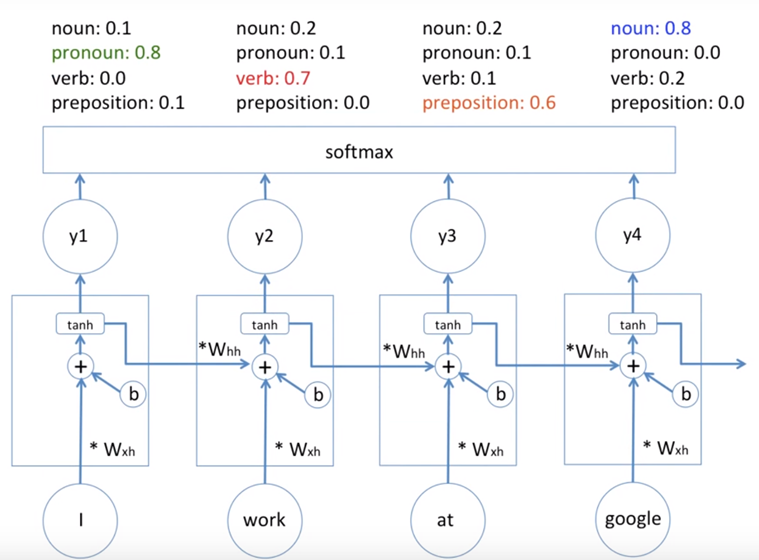

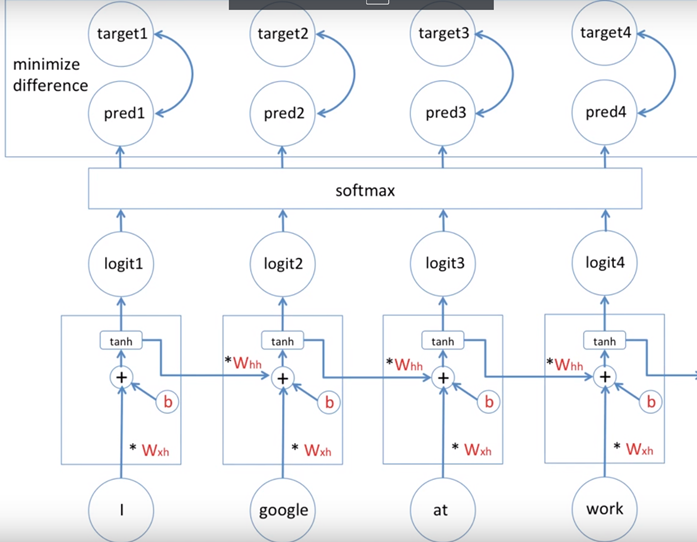

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pprint import pprint
from tensorflow.python.keras.preprocessing.text import Tokenizer
%matplotlib inline

print(tf.__version__)
print(keras.__version__)
tf.enable_eager_execution()

1.13.1
2.2.4-tf


In [2]:
X_train = [['I', 'feel', 'hungry'],
           ['tensorflow', 'is', 'very', 'difficult'],
           ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
           ['tensorflow', 'is', 'very', 'fast', 'changing']]

Y_train = [['pronoun', 'verb', 'adjective'],
           ['noun', 'verb', 'adverb', 'adjective'],
           ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
           ['noun', 'verb', 'adverb', 'adjective', 'verb']]

In [3]:
xtokenizer = Tokenizer()
xtokenizer.fit_on_texts(X_train)
X_train_tokens = xtokenizer.texts_to_sequences(X_train)
X_train_tokens

[[4, 5, 6], [1, 2, 3, 7], [1, 2, 8, 9, 10, 11, 12], [1, 2, 3, 13, 14]]

In [4]:
xreverse_word_map = dict(map(reversed, xtokenizer.word_index.items()))
xreverse_word_map

{1: 'tensorflow',
 2: 'is',
 3: 'very',
 4: 'i',
 5: 'feel',
 6: 'hungry',
 7: 'difficult',
 8: 'a',
 9: 'framework',
 10: 'for',
 11: 'deep',
 12: 'learning',
 13: 'fast',
 14: 'changing'}

In [5]:
max_sequence = 7

In [6]:
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_sequence, padding='post')
X_train_pad

array([[ 4,  5,  6,  0,  0,  0,  0],
       [ 1,  2,  3,  7,  0,  0,  0],
       [ 1,  2,  8,  9, 10, 11, 12],
       [ 1,  2,  3, 13, 14,  0,  0]])

In [7]:
x_kind_num = len(xreverse_word_map) + 1 # X_train의 글자의 종류 수 + 0(padding)
x_kind_num

15

In [8]:
ytokenizer = Tokenizer()
ytokenizer.fit_on_texts(Y_train)
Y_train_tokens = ytokenizer.texts_to_sequences(Y_train)
Y_train_tokens

[[5, 1, 3], [2, 1, 4, 3], [2, 1, 6, 2, 7, 3, 2], [2, 1, 4, 3, 1]]

In [9]:
yreverse_word_map = dict(map(reversed, ytokenizer.word_index.items()))
yreverse_word_map

{1: 'verb',
 2: 'noun',
 3: 'adjective',
 4: 'adverb',
 5: 'pronoun',
 6: 'determiner',
 7: 'preposition'}

In [10]:
Y_train_pad = pad_sequences(Y_train_tokens, maxlen=max_sequence, padding='post')
Y_train_pad

array([[5, 1, 3, 0, 0, 0, 0],
       [2, 1, 4, 3, 0, 0, 0],
       [2, 1, 6, 2, 7, 3, 2],
       [2, 1, 4, 3, 1, 0, 0]])

In [11]:
y_kind_num = len(yreverse_word_map) + 1
y_kind_num

8

In [12]:
num_classes = y_kind_num     # y 종류 (7품사 + 1)
hidden_dim = 4               # RNN의 선형회귀를 몇 번 할 건지

input_dim = x_kind_num
output_dim = x_kind_num

one_hot = np.eye(x_kind_num)
one_hot

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0.

In [13]:
model = Sequential()
model.add(layers.Embedding(input_dim=input_dim,
                           output_dim=output_dim,
                           mask_zero=True,           # False 시 출력 [0, 1, 0, ...] 에서 1 앞의 0 제거
                           trainable=False,          #
                           input_length=max_sequence,
                           embeddings_initializer=keras.initializers.Constant(one_hot)))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 15)             225       
Total params: 225
Trainable params: 0
Non-trainable params: 225
_________________________________________________________________


In [14]:
matrix1 = model(X_train_pad)
matrix1

<tf.Tensor: id=20, shape=(4, 7, 15), dtype=float32, numpy=
array([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 

In [15]:
hidden_dim = 8               # RNN의 선형회귀를 몇 번 할 건지

model.add(layers.SimpleRNN(units=hidden_dim, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 15)             225       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 7, 8)              192       
Total params: 417
Trainable params: 192
Non-trainable params: 225
_________________________________________________________________


In [16]:
matrix2 = model(X_train_pad)
matrix2

<tf.Tensor: id=470, shape=(4, 7, 8), dtype=float32, numpy=
array([[[ 0.4662977 ,  0.24058978, -0.00875147, -0.34288862,
         -0.30593634, -0.09289027,  0.07442058,  0.01348324],
        [-0.286024  ,  0.45931065,  0.53696203, -0.7197386 ,
         -0.5845794 , -0.02922072,  0.36924854, -0.30724874],
        [ 0.5662224 , -0.26639083, -0.34330705, -0.69879067,
         -0.6747611 ,  0.5776607 ,  0.66557   , -0.04366962],
        [ 0.5662224 , -0.26639083, -0.34330705, -0.69879067,
         -0.6747611 ,  0.5776607 ,  0.66557   , -0.04366962],
        [ 0.5662224 , -0.26639083, -0.34330705, -0.69879067,
         -0.6747611 ,  0.5776607 ,  0.66557   , -0.04366962],
        [ 0.5662224 , -0.26639083, -0.34330705, -0.69879067,
         -0.6747611 ,  0.5776607 ,  0.66557   , -0.04366962],
        [ 0.5662224 , -0.26639083, -0.34330705, -0.69879067,
         -0.6747611 ,  0.5776607 ,  0.66557   , -0.04366962]],

       [[-0.13267411,  0.33324754,  0.3424821 ,  0.24290404,
         -0.18479

In [17]:
model.add(layers.TimeDistributed(layers.Dense(units=num_classes, activation=tf.nn.softmax)))
# layers.TimeDistributed: softmax, cost func를 마지막 결과 1번만 하는게 아니라, 시간순으로 한번씩 다 해준다. (젤 위 그림 두 장 참조)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 15)             225       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 7, 8)              192       
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 8)              72        
Total params: 489
Trainable params: 264
Non-trainable params: 225
_________________________________________________________________


In [18]:
matrix3 = model(X_train_pad)
matrix3

<tf.Tensor: id=905, shape=(4, 7, 8), dtype=float32, numpy=
array([[[0.18392876, 0.1319934 , 0.12512478, 0.10075317, 0.081558  ,
         0.10316803, 0.14145888, 0.13201505],
        [0.15683596, 0.08581188, 0.08114   , 0.10907836, 0.05772581,
         0.22509106, 0.07732601, 0.20699099],
        [0.24798173, 0.14103284, 0.11504287, 0.07779747, 0.14051451,
         0.08263914, 0.07950577, 0.11548563],
        [0.24798173, 0.14103284, 0.11504287, 0.07779747, 0.14051451,
         0.08263914, 0.07950577, 0.11548563],
        [0.24798173, 0.14103284, 0.11504287, 0.07779747, 0.14051451,
         0.08263914, 0.07950577, 0.11548563],
        [0.24798173, 0.14103284, 0.11504287, 0.07779747, 0.14051451,
         0.08263914, 0.07950577, 0.11548563],
        [0.24798173, 0.14103284, 0.11504287, 0.07779747, 0.14051451,
         0.08263914, 0.07950577, 0.11548563]],

       [[0.11487806, 0.13101192, 0.10001701, 0.1055854 , 0.11109199,
         0.13681895, 0.17399676, 0.12659995],
        [0.11978493

## RNN many to many

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pprint import pprint
from tensorflow.python.keras.preprocessing.text import Tokenizer
%matplotlib inline

tf.enable_eager_execution()

X_train = [['I', 'feel', 'hungry'],
           ['tensorflow', 'is', 'very', 'difficult'],
           ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
           ['tensorflow', 'is', 'very', 'fast', 'changing']]

Y_train = [['pronoun', 'verb', 'adjective'],
           ['noun', 'verb', 'adverb', 'adjective'],
           ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
           ['noun', 'verb', 'adverb', 'adjective', 'verb']]

xtokenizer = Tokenizer()
xtokenizer.fit_on_texts(X_train)
X_train_tokens = xtokenizer.texts_to_sequences(X_train)

xreverse_word_map = dict(map(reversed, xtokenizer.word_index.items()))

max_sequence = 7

X_train_pad = pad_sequences(X_train_tokens, maxlen=max_sequence, padding='post')
X_train_pad

x_kind_num = len(xreverse_word_map) + 1 # X_train의 글자의 종류 수 + 0(padding)

ytokenizer = Tokenizer()
ytokenizer.fit_on_texts(Y_train)
Y_train_tokens = ytokenizer.texts_to_sequences(Y_train)

yreverse_word_map = dict(map(reversed, ytokenizer.word_index.items()))

Y_train_pad = pad_sequences(Y_train_tokens, maxlen=max_sequence, padding='post')

y_kind_num = len(yreverse_word_map) + 1

num_classes = y_kind_num     # y 종류 (7품사 + 1)

input_dim = x_kind_num
output_dim = x_kind_num

one_hot = np.eye(x_kind_num)

model = Sequential()
model.add(layers.Embedding(input_dim=input_dim,
                           output_dim=output_dim,
                           mask_zero=True,           # False 시 출력 [0, 1, 0, ...] 에서 1 앞의 0 제거
                           trainable=False,          #
                           input_length=max_sequence,
                           embeddings_initializer=keras.initializers.Constant(one_hot)))

matrix1 = model(X_train_pad)

hidden_dim = 8               # RNN의 선형회귀를 몇 번 할 건지

model.add(layers.SimpleRNN(units=hidden_dim, return_sequences=True))

matrix2 = model(X_train_pad)

model.add(layers.TimeDistributed(layers.Dense(units=num_classes, activation=tf.nn.softmax)))
# layers.TimeDistributed: softmax, cost func를 마지막 결과 1번만 하는게 아니라, 시간순으로 한번씩 다 해준다. (젤 위 그림 두 장 참조)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 7, 15)             225       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 7, 8)              192       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 8)              72        
Total params: 489
Trainable params: 264
Non-trainable params: 225
_________________________________________________________________


In [20]:
lr = .001 # learning rate
opt = tf.train.AdamOptimizer(learning_rate = lr)

x_train_len = list(map(lambda sentence: len(sentence), X_train))  # X_train 각 줄의 데이터 개수를 변수에 저장
x_train_len

[3, 4, 7, 5]

In [21]:
masking = tf.sequence_mask(x_train_len, maxlen=max_sequence, dtype=tf.float32)
# x_train_len에 저장된 각 줄의 수만큼 1이 저장된 배열 생성
masking

<tf.Tensor: id=1421, shape=(4, 7), dtype=float32, numpy=
array([[1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0.]], dtype=float32)>

In [22]:
valid_time_step = tf.cast(x_train_len, dtype=tf.float32)
valid_time_step

<tf.Tensor: id=1424, shape=(4,), dtype=float32, numpy=array([3., 4., 7., 5.], dtype=float32)>

In [23]:
for step in range(1000):
    with tf.GradientTape() as tape:
        hypothesis = model(X_train_pad)
        cost = tf.losses.sparse_softmax_cross_entropy(labels=Y_train_pad,
                                                      logits=hypothesis,
                                                      reduction='none') * masking
        # cost를 계산하고 masking과 곱해서, X_train_pad에서 데이터가 없는 칸의 cost 삭제
        cost = tf.reduce_sum(cost, axis=-1) / valid_time_step
        cost = tf.reduce_mean(cost)
        
    grads = tape.gradient(target=cost, sources=model.variables)
    opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
    
    if step % 100 == 0:
        print('step: {:3}, cost: {:.3f}'.format(step, cost))

Instructions for updating:
Use tf.cast instead.
step:   0, cost: 2.075
step: 100, cost: 1.916
step: 200, cost: 1.715
step: 300, cost: 1.570
step: 400, cost: 1.461
step: 500, cost: 1.404
step: 600, cost: 1.373
step: 700, cost: 1.349
step: 800, cost: 1.335
step: 900, cost: 1.319


In [24]:
yhat = model.predict(X_train_pad)  # 각 품사의 예측치 계산
yhat

array([[[6.79717259e-03, 2.45575234e-03, 7.86146522e-03, 6.33646175e-03,
         1.51902364e-04, 9.69887912e-01, 9.24833352e-04, 5.58455382e-03],
        [8.44617432e-04, 9.85346437e-01, 1.21907960e-03, 4.21964476e-04,
         4.51964152e-04, 1.53883977e-03, 6.72280148e-04, 9.50485561e-03],
        [7.29367370e-04, 1.01804640e-03, 1.37628429e-02, 9.79063034e-01,
         2.67494284e-03, 5.17531007e-04, 2.21907161e-03, 1.52234243e-05],
        [7.29367370e-04, 1.01804640e-03, 1.37628429e-02, 9.79063034e-01,
         2.67494284e-03, 5.17531007e-04, 2.21907161e-03, 1.52234243e-05],
        [7.29367370e-04, 1.01804640e-03, 1.37628429e-02, 9.79063034e-01,
         2.67494284e-03, 5.17531007e-04, 2.21907161e-03, 1.52234243e-05],
        [7.29367370e-04, 1.01804640e-03, 1.37628429e-02, 9.79063034e-01,
         2.67494284e-03, 5.17531007e-04, 2.21907161e-03, 1.52234243e-05],
        [7.29367370e-04, 1.01804640e-03, 1.37628429e-02, 9.79063034e-01,
         2.67494284e-03, 5.17531007e-04, 2.21

In [25]:
yhat = np.argmax(yhat, axis=-1)  # 각 row의 가장 확률 높은 col index return
yhat

array([[5, 1, 3, 3, 3, 3, 3],
       [2, 1, 4, 3, 3, 3, 3],
       [2, 1, 6, 2, 7, 3, 2],
       [2, 1, 4, 3, 1, 1, 1]], dtype=int64)

In [30]:
X_train_pad

array([[ 4,  5,  6,  0,  0,  0,  0],
       [ 1,  2,  3,  7,  0,  0,  0],
       [ 1,  2,  8,  9, 10, 11, 12],
       [ 1,  2,  3, 13, 14,  0,  0]])

In [28]:
X_train_pad !=0

array([[ True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True, False, False]])

In [37]:
x_train_mask = ((X_train_pad !=0)).astype(np.float32)  # X_train_pad에서 0이 아니면 조건이 True므로 1 리턴. 아니면 0 리턴
x_train_mask

array([[1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0.]], dtype=float32)

In [38]:
pre = yhat * x_train_mask
pre

array([[5., 1., 3., 0., 0., 0., 0.],
       [2., 1., 4., 3., 0., 0., 0.],
       [2., 1., 6., 2., 7., 3., 2.],
       [2., 1., 4., 3., 1., 0., 0.]])

In [39]:
Y_train_pad

array([[5, 1, 3, 0, 0, 0, 0],
       [2, 1, 4, 3, 0, 0, 0],
       [2, 1, 6, 2, 7, 3, 2],
       [2, 1, 4, 3, 1, 0, 0]])

In [40]:
pre == Y_train_pad

array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]])

In [42]:
accuracy = np.mean(tf.cast(pre==Y_train_pad, dtype=np.float32))
accuracy

1.0

In [43]:
yreverse_word_map[1]

'verb'

In [44]:
yreverse_word_map[2]

'noun'

In [46]:
for ypre1 in pre:
    pre_list=[]
    for ypre2 in ypre1:
        if (ypre2 != 0):
            pre_list.append(yreverse_word_map[ypre2] + "  ")
    print(pre_list)

['pronoun  ', 'verb  ', 'adjective  ']
['noun  ', 'verb  ', 'adverb  ', 'adjective  ']
['noun  ', 'verb  ', 'determiner  ', 'noun  ', 'preposition  ', 'adjective  ', 'noun  ']
['noun  ', 'verb  ', 'adverb  ', 'adjective  ', 'verb  ']


In [47]:
X_train

[['I', 'feel', 'hungry'],
 ['tensorflow', 'is', 'very', 'difficult'],
 ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
 ['tensorflow', 'is', 'very', 'fast', 'changing']]

In [48]:
Y_train

[['pronoun', 'verb', 'adjective'],
 ['noun', 'verb', 'adverb', 'adjective'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb']]

- Test data

In [49]:
X_test = [
    ['tensorflow', 'is', 'google'],
    ['I', 'google', 'for', 'deep', 'learning']
]

In [50]:
X_test_tokens = xtokenizer.texts_to_sequences(X_test)
X_test_tokens

[[1, 2], [4, 10, 11, 12]]

In [51]:
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_sequence, padding='post')
X_test_pad

array([[ 1,  2,  0,  0,  0,  0,  0],
       [ 4, 10, 11, 12,  0,  0,  0]])

In [52]:
X_test_mask = ((X_test_pad != 0)).astype(np.float32)  # 각 row에서 데이터가 저장된 col에 1 아닌 col에 0 대입
X_test_mask

array([[1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0.]], dtype=float32)

In [53]:
yhat = model.predict(X_test_pad)  # 각 데이터 품사 예측치 계산
yhat

array([[[5.9802126e-04, 5.0254785e-03, 9.7181487e-01, 1.5380151e-02,
         8.4046269e-04, 3.5705392e-03, 2.5066037e-03, 2.6377494e-04],
        [4.6415054e-04, 9.8313028e-01, 5.9836279e-03, 3.2884494e-04,
         4.4927286e-04, 1.9738488e-03, 1.7612809e-03, 5.9087719e-03],
        [4.6415054e-04, 9.8313028e-01, 5.9836279e-03, 3.2884494e-04,
         4.4927286e-04, 1.9738488e-03, 1.7612809e-03, 5.9087719e-03],
        [4.6415054e-04, 9.8313028e-01, 5.9836279e-03, 3.2884494e-04,
         4.4927286e-04, 1.9738488e-03, 1.7612809e-03, 5.9087719e-03],
        [4.6415054e-04, 9.8313028e-01, 5.9836279e-03, 3.2884494e-04,
         4.4927286e-04, 1.9738488e-03, 1.7612809e-03, 5.9087719e-03],
        [4.6415054e-04, 9.8313028e-01, 5.9836279e-03, 3.2884494e-04,
         4.4927286e-04, 1.9738488e-03, 1.7612809e-03, 5.9087719e-03],
        [4.6415054e-04, 9.8313028e-01, 5.9836279e-03, 3.2884494e-04,
         4.4927286e-04, 1.9738488e-03, 1.7612809e-03, 5.9087719e-03]],

       [[6.7971726e-03, 2

In [54]:
yhat = np.argmax(yhat, axis=-1)
yhat

array([[2, 1, 1, 1, 1, 1, 1],
       [5, 1, 3, 2, 2, 2, 2]], dtype=int64)

In [56]:
pre = yhat * X_test_mask   # 데이터가 없는 col의 데이터를 0으로 변환
pre

array([[2., 1., 0., 0., 0., 0., 0.],
       [5., 1., 3., 2., 0., 0., 0.]])

In [57]:
for ypre1 in pre:
    pre_list=[]
    for ypre2 in ypre1:
        if (ypre2!=0):
            pre_list.append(yreverse_word_map[ypre2] + "  ")
    print(pre_list)

['noun  ', 'verb  ']
['pronoun  ', 'verb  ', 'adjective  ', 'noun  ']


In [58]:
X_test

[['tensorflow', 'is', 'google'], ['I', 'google', 'for', 'deep', 'learning']]